In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bcml4pheno import bcml_model
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

2022-06-07 21:46:42.304752: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /Collider/ROOT/installROOT/lib:/Collider/ROOT/installROOT/lib::/Collider/ROOT/installROOT/lib/:/Collider/fastjet/lib:/Collider/fastjet/lib64:/Collider/LHAPDF/lib
2022-06-07 21:46:42.304785: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
ReadFolder = 'DataFiles'

current_path = os.getcwd() + '/' + ReadFolder
files=next(os.walk(current_path))[2]

csv_files=[]
for file in files:
    if '.csv' in file:
            csv_files+=[file]
csv_files.sort()

def read_csv(file):
    df = pd.read_csv(ReadFolder+'/'+file)
    return file.removesuffix('.csv'), df

data_dict=dict(map(read_csv, csv_files))

In [3]:
eff_dict = {}
for signal in data_dict:
    print("{}: {}".format(signal, len(data_dict[signal])))
    if 'SingleLQ' in signal:
        eff_dict[signal] = len(data_dict[signal])/500000.
    elif 'ttbar' in signal:
        eff_dict[signal] = len(data_dict[signal])/24307250.
    elif 'DYw' in signal:
        eff_dict[signal] = len(data_dict[signal])/20942823.
    elif 'DYz' in signal:
        eff_dict[signal] = len(data_dict[signal])/18505572.
    elif 'DBww' in signal:
        eff_dict[signal] = len(data_dict[signal])/12500000.
    elif 'DBzz' in signal:
        eff_dict[signal] = len(data_dict[signal])/10000000.
    elif 'DBwz' in signal:
        eff_dict[signal] = len(data_dict[signal])/9850000.


SingleLQ_0500_electrons: 24569
SingleLQ_0500_muons: 29597
SingleLQ_1000_electrons: 26498
SingleLQ_1000_muons: 31115
SingleLQ_1500_electrons: 25478
SingleLQ_1500_muons: 30127
SingleLQ_2000_electrons: 24133
SingleLQ_2000_muons: 28172
SingleLQ_2500_electrons: 24368
SingleLQ_2500_muons: 28417
SingleLQ_3000_electrons: 25922
SingleLQ_3000_muons: 30361
SingleLQ_3500_electrons: 22627
SingleLQ_3500_muons: 26700
bkg_DBww_electrons: 460
bkg_DBww_muons: 564
bkg_DBzz_electrons: 865
bkg_DBzz_muons: 908
bkg_DYw_electrons: 31
bkg_DYw_muons: 31
bkg_DYz_electrons: 39
bkg_DYz_muons: 41
bkg_ttbar_electrons: 55118
bkg_ttbar_muons: 72407


In [4]:
x_sect = {}
with open('BkgCrossSections.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        x_sect[row[0]] = float(row[1])
        
with open('DecayWidths-CrossSections.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        if int(row[0]) < 1000:
            name = 'SingleLQ_0{}'.format(row[0])
        else:
            name = 'SingleLQ_{}'.format(row[0])
        x_sect[name] = float(row[2])

In [5]:
phys_events_e = {}
phys_events_mu = {}
for signal in x_sect:
    if 'bkg' in signal and 'wz' not in signal:
        eff = eff_dict[signal+'_electrons'] * x_sect[signal]
        muff= eff_dict[signal+'_muons'] * x_sect[signal]
        phys_events_e[signal] = eff
        phys_events_mu[signal] = muff
        

In [6]:
def prepare_to_train (signal, bkgs=[]):
    bkg_vsize=min(len(bkgs[x])for x in range(len(bkgs)))
    if (len(signal)>=len(bkgs)*bkg_vsize):
        signal_vsize=len(bkgs)*bkg_vsize
    else: 
        signal_vsize=len(signal)-len(signal)%len(bkgs)
        bkg_vsize=int(signal_vsize/len(bkgs))

    pred=signal.head(signal_vsize)
    for bkg in bkgs:
        pred=pd.concat([pred,bkg.head(bkg_vsize)],axis=0)

    labels=np.zeros(np.shape(pred)[0])
    labels[:signal_vsize] = 1
    
    return pred, labels

In [7]:
def LogReg(mass, lpt=1):
    if lpt==1:
        bkgs=[]
        bkgs.append(data_dict["bkg_ttbar_electrons"])
        
        if mass < 1000:
            signal_name = 'SingleLQ_0{}_electrons'.format(mass)
        else:
            signal_name = 'SingleLQ_{}_electrons'.format(mass)

    elif lpt==2:
        bkgs=[]
        bkgs.append(data_dict["bkg_ttbar_muons"])
        
        if mass < 1000:
            signal_name = 'SingleLQ_0{}_muons'.format(mass)
        else:
            signal_name = 'SingleLQ_{}_muons'.format(mass)
    else:
        print('Invalid lpt input.')
        
    pred1 , labels1= prepare_to_train(data_dict[signal_name],bkgs)
    trainPred, testPred, trainLab, testLab = train_test_split(pred1, labels1, test_size=0.25)


    logreg_model = bcml_model(make_pipeline(StandardScaler(), LogisticRegression()))

    logreg_model.fit(trainPred, trainLab)

    return logreg_model, testPred, testLab

In [8]:
def LogRegPCA(mass, lpt=1, pca_level=0.9):
    if lpt==1:
        bkgs=[]
        bkgs.append(data_dict["bkg_ttbar_electrons"])
        
        if mass < 1000:
            signal_name = 'SingleLQ_0{}_electrons'.format(mass)
        else:
            signal_name = 'SingleLQ_{}_electrons'.format(mass)
            
    elif lpt==2:
        bkgs=[]
        bkgs.append(data_dict["bkg_ttbar_muons"])
        
        if mass < 1000:
            signal_name = 'SingleLQ_0{}_muons'.format(mass)
        else:
            signal_name = 'SingleLQ_{}_muons'.format(mass)
            
    else:
        print('Invalid lpt input.')
        
    pred1 , labels1= prepare_to_train(data_dict[signal_name],bkgs)

    pred1 = StandardScaler().fit_transform(pred1)

    trainPred, testPred, trainLab, testLab = train_test_split(pred1, labels1, test_size=0.25)

    pca = PCA(pca_level)
    pca.fit(trainPred)

    trainPred_PCA = pca.transform(trainPred)
    testPred_PCA = pca.transform(testPred)


    logreg_model = bcml_model(make_pipeline(StandardScaler(), LogisticRegression()))

    logreg_model.fit(trainPred_PCA, trainLab)

    return logreg_model, testPred_PCA, testLab

In [9]:
def CalculateYields(lum, mass, lpt=1):
    conv = 1.0e3
    if mass < 1000:
        signal_name = 'SingleLQ_0{}'.format(mass)
    else:
        signal_name = 'SingleLQ_{}'.format(mass)
        
    sig_cs = x_sect[signal_name]
    bkg_cs = x_sect['bkg_ttbar']
    
    if lpt==1:
        sig_eff = eff_dict[signal_name+'_electrons']
        bkg_eff = eff_dict['bkg_ttbar_electrons']
    
    elif lpt==2:
        sig_eff = eff_dict[signal_name+'_muons']
        bkg_eff = eff_dict['bkg_ttbar_muons']
    
    sig_yield = conv * lum * sig_cs * sig_eff
    bkg_yield = conv * lum * bkg_cs * bkg_eff

    return sig_yield, bkg_yield

In [10]:
try:
    !mkdir LogReg
except:
    pass

mkdir: cannot create directory ‘LogReg’: File exists


In [11]:
mod_dict = {}
mod_dictPCA = {}

# masses = [500, 1000, 1500, 2000, 2500, 3000, 3500]

# for mass in masses:
#     mod1, testPred1, testLab1 = LogReg(mass)
#     mod2, testPred2, testLab2 = LogReg(mass, lpt=2)
    
#     name = 'SingleLQ{:0>4}-'.format(mass)
    
#     mod_dict[name+'electrons'] = (mod1, testPred1, testLab1)
#     mod_dict[name+'muons'] = (mod2, testPred2, testLab2)
    
#     mod1, testPred1, testLab1 = LogRegPCA(mass, pca_level=0.95)
#     mod2, testPred2, testLab2 = LogRegPCA(mass, pca_level=0.95, lpt=2)
    
#     mod_dict[name+'electrons'] = (mod1, testPred1, testLab1)
#     mod_dict[name+'muons'] = (mod2, testPred2, testLab2)

# Logistic Regression Algorithm

### Electronic channel (No PCA)

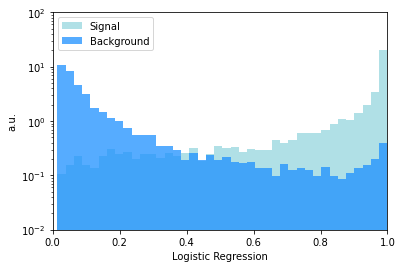

In [12]:
mass = 500

mod, testPred, testLab = LogReg(mass)
mod_dict['SingleLQ{:0>4}-electrons'.format(mass)] = (mod, testPred, testLab)
# sig_yield, bkg_yield = CalculateYields(lumi, mass)

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
# plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
# plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
# plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Logistic Regression')
plt.ylabel('a.u.')

plt.legend()
plt.show()
# plt.savefig('LogReg/LogReg_LQ500_electrons.pdf')

/usr/local/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


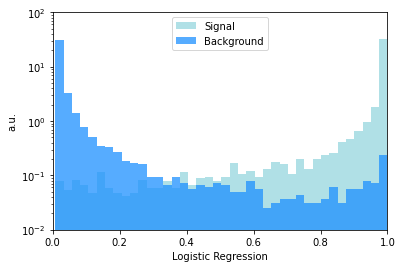

In [13]:
mass = 1000

mod, testPred, testLab = LogReg(mass)
mod_dict['SingleLQ{:0>4}-electrons'.format(mass)] = (mod, testPred, testLab)
# sig_yield, bkg_yield = CalculateYields(lumi, mass)

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
# plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
# plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
# plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Logistic Regression')
plt.ylabel('a.u.')

plt.legend()
plt.show()
# plt.savefig('LogReg/LogReg_LQ500_electrons.pdf')

/usr/local/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


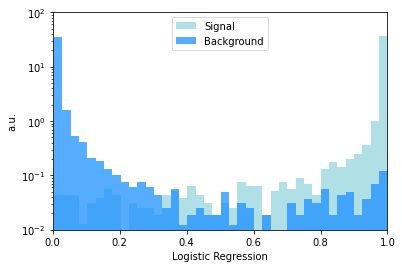

In [14]:
mass = 1500

mod, testPred, testLab = LogReg(mass)
mod_dict['SingleLQ{:0>4}-electrons'.format(mass)] = (mod, testPred, testLab)
# sig_yield, bkg_yield = CalculateYields(lumi, mass)

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
# plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
# plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
# plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Logistic Regression')
plt.ylabel('a.u.')

plt.legend()
plt.show()
# plt.savefig('LogReg/LogReg_LQ500_electrons.pdf')

/usr/local/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


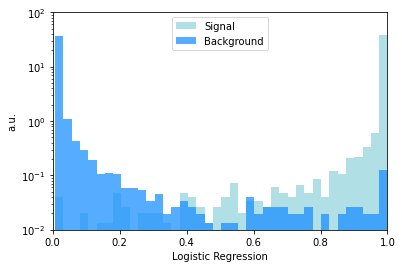

In [15]:
mass = 2000

mod, testPred, testLab = LogReg(mass)
mod_dict['SingleLQ{:0>4}-electrons'.format(mass)] = (mod, testPred, testLab)
# sig_yield, bkg_yield = CalculateYields(lumi, mass)

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
# plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
# plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
# plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Logistic Regression')
plt.ylabel('a.u.')

plt.legend()
plt.show()
# plt.savefig('LogReg/LogReg_LQ500_electrons.pdf')

/usr/local/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


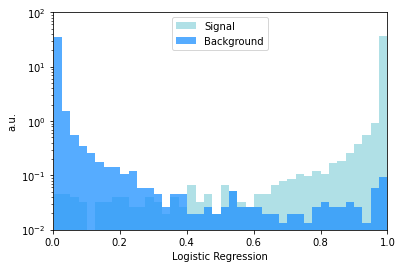

In [16]:
mass = 2500

mod, testPred, testLab = LogReg(mass)
mod_dict['SingleLQ{:0>4}-electrons'.format(mass)] = (mod, testPred, testLab)
# sig_yield, bkg_yield = CalculateYields(lumi, mass)

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
# plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
# plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
# plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Logistic Regression')
plt.ylabel('a.u.')

plt.legend()
plt.show()
# plt.savefig('LogReg/LogReg_LQ500_electrons.pdf')

/usr/local/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


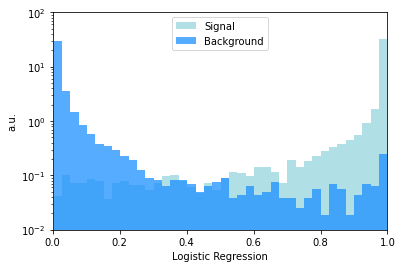

In [17]:
mass = 3000

mod, testPred, testLab = LogReg(mass)
mod_dict['SingleLQ{:0>4}-electrons'.format(mass)] = (mod, testPred, testLab)
# sig_yield, bkg_yield = CalculateYields(lumi, mass)

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
# plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
# plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
# plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Logistic Regression')
plt.ylabel('a.u.')

plt.legend()
plt.show()
# plt.savefig('LogReg/LogReg_LQ500_electrons.pdf')

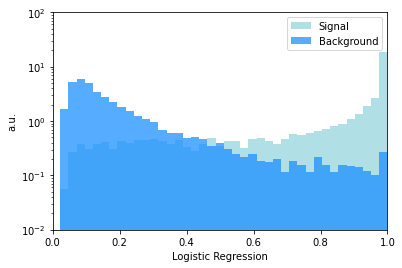

In [18]:
mass = 3500

mod, testPred, testLab = LogReg(mass)
mod_dict['SingleLQ{:0>4}-electrons'.format(mass)] = (mod, testPred, testLab)
# sig_yield, bkg_yield = CalculateYields(lumi, mass)

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
# plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
# plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
# plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Logistic Regression')
plt.ylabel('a.u.')

plt.legend()
plt.show()
# plt.savefig('LogReg/LogReg_LQ500_electrons.pdf')

### Muonic channel (No PCA)

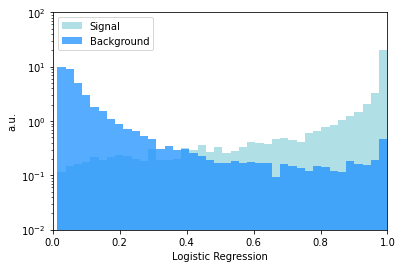

In [19]:
mass = 500

mod, testPred, testLab = LogReg(mass, lpt=2)
mod_dict['SingleLQ{:0>4}-muons'.format(mass)] = (mod, testPred, testLab)
# sig_yield, bkg_yield = CalculateYields(lumi, mass)

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
# plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
# plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
# plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Logistic Regression')
plt.ylabel('a.u.')

plt.legend()
plt.show()
#plt.savefig('LogReg/LogReg_LQ500_muons.pdf')

/usr/local/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


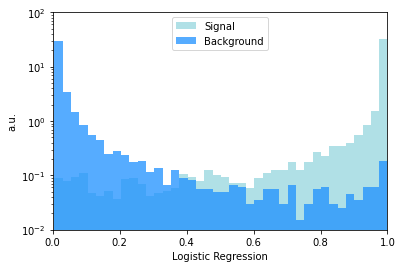

In [20]:
mass = 1000

mod, testPred, testLab = LogReg(mass, lpt=2)
mod_dict['SingleLQ{:0>4}-muons'.format(mass)] = (mod, testPred, testLab)
# sig_yield, bkg_yield = CalculateYields(lumi, mass)

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
# plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
# plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
# plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Logistic Regression')
plt.ylabel('a.u.')

plt.legend()
plt.show()
#plt.savefig('LogReg/LogReg_LQ500_muons.pdf')

/usr/local/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


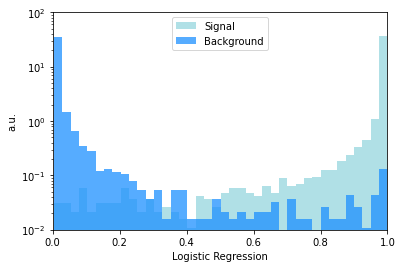

In [21]:
mass = 1500

mod, testPred, testLab = LogReg(mass, lpt=2)
mod_dict['SingleLQ{:0>4}-muons'.format(mass)] = (mod, testPred, testLab)
# sig_yield, bkg_yield = CalculateYields(lumi, mass)

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
# plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
# plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
# plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Logistic Regression')
plt.ylabel('a.u.')

plt.legend()
plt.show()
#plt.savefig('LogReg/LogReg_LQ500_muons.pdf')

/usr/local/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


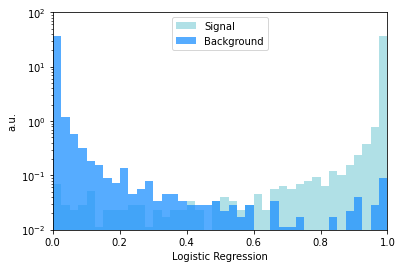

In [22]:
mass = 2000

mod, testPred, testLab = LogReg(mass, lpt=2)
mod_dict['SingleLQ{:0>4}-muons'.format(mass)] = (mod, testPred, testLab)
# sig_yield, bkg_yield = CalculateYields(lumi, mass)

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
# plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
# plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
# plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Logistic Regression')
plt.ylabel('a.u.')

plt.legend()
plt.show()
#plt.savefig('LogReg/LogReg_LQ500_muons.pdf')

/usr/local/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


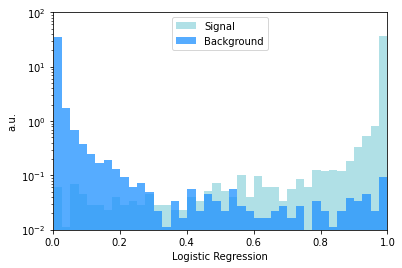

In [23]:
mass = 2500

mod, testPred, testLab = LogReg(mass, lpt=2)
mod_dict['SingleLQ{:0>4}-muons'.format(mass)] = (mod, testPred, testLab)
# sig_yield, bkg_yield = CalculateYields(lumi, mass)

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
# plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
# plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
# plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Logistic Regression')
plt.ylabel('a.u.')

plt.legend()
plt.show()
#plt.savefig('LogReg/LogReg_LQ500_muons.pdf')

/usr/local/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


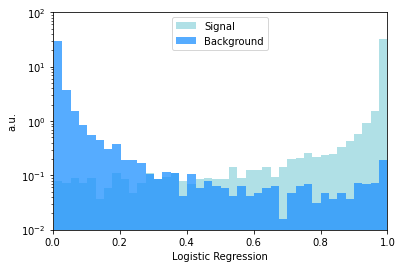

In [24]:
mass = 3000

mod, testPred, testLab = LogReg(mass, lpt=2)
mod_dict['SingleLQ{:0>4}-muons'.format(mass)] = (mod, testPred, testLab)
# sig_yield, bkg_yield = CalculateYields(lumi, mass)

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
# plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
# plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
# plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Logistic Regression')
plt.ylabel('a.u.')

plt.legend()
plt.show()
#plt.savefig('LogReg/LogReg_LQ500_muons.pdf')

/usr/local/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


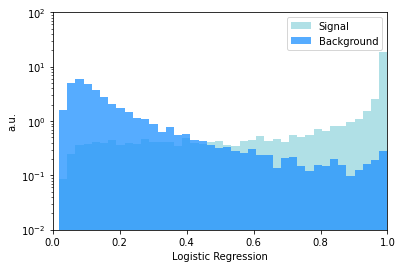

In [25]:
mass = 3500

mod, testPred, testLab = LogReg(mass, lpt=2)
mod_dict['SingleLQ{:0>4}-muons'.format(mass)] = (mod, testPred, testLab)
# sig_yield, bkg_yield = CalculateYields(lumi, mass)

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
# plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
# plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
# plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Logistic Regression')
plt.ylabel('a.u.')

plt.legend()
plt.show()
#plt.savefig('LogReg/LogReg_LQ500_muons.pdf')

### With PCA for non-convergent data sets

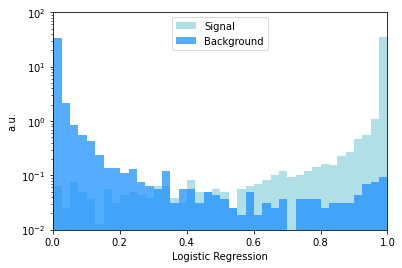

In [26]:
mass = 1500

mod, testPred, testLab = LogRegPCA(mass, pca_level=0.95)
mod_dictPCA['SingleLQ{:0>4}-electrons'.format(mass)] = (mod, testPred, testLab)
# sig_yield, bkg_yield = CalculateYields(lumi, mass)

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
# plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
# plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
# plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Logistic Regression')
plt.ylabel('a.u.')

plt.legend()
plt.show()

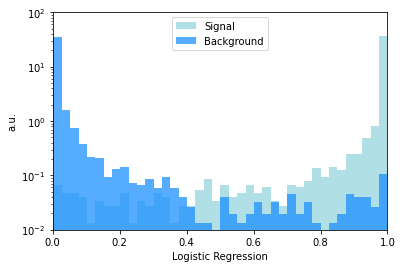

In [27]:
mass = 2000

mod, testPred, testLab = LogRegPCA(mass, pca_level=0.95)
mod_dictPCA['SingleLQ{:0>4}-electrons'.format(mass)] = (mod, testPred, testLab)
# sig_yield, bkg_yield = CalculateYields(lumi, mass)

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
# plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
# plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
# plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Logistic Regression')
plt.ylabel('a.u.')

plt.legend()
plt.show()

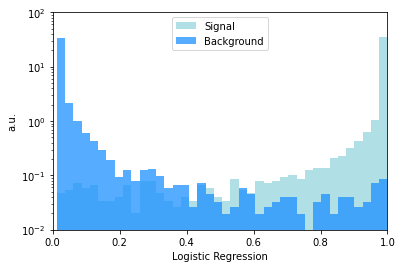

In [28]:
mass = 2500

mod, testPred, testLab = LogRegPCA(mass, pca_level=0.95)
mod_dictPCA['SingleLQ{:0>4}-electrons'.format(mass)] = (mod, testPred, testLab)
# sig_yield, bkg_yield = CalculateYields(lumi, mass)

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
# plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
# plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
# plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Logistic Regression')
plt.ylabel('a.u.')

plt.legend()
plt.show()

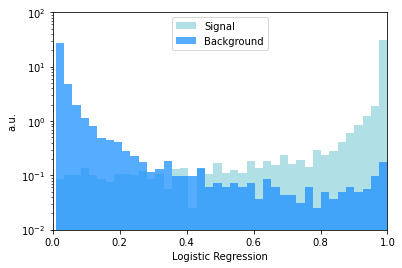

In [29]:
mass = 3000

mod, testPred, testLab = LogRegPCA(mass, pca_level=0.95)
mod_dictPCA['SingleLQ{:0>4}-electrons'.format(mass)] = (mod, testPred, testLab)
# sig_yield, bkg_yield = CalculateYields(lumi, mass)

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
# plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
# plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
# plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Logistic Regression')
plt.ylabel('a.u.')

plt.legend()
plt.show()

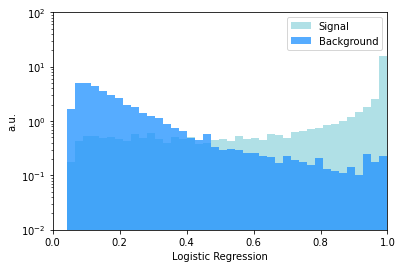

In [30]:
mass = 3500

mod, testPred, testLab = LogRegPCA(mass, pca_level=0.95)
mod_dictPCA['SingleLQ{:0>4}-electrons'.format(mass)] = (mod, testPred, testLab)
# sig_yield, bkg_yield = CalculateYields(lumi, mass)

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
# plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
# plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
# plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Logistic Regression')
plt.ylabel('a.u.')

plt.legend()
plt.show()

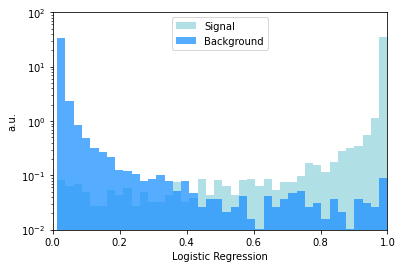

In [31]:
mass = 1500

mod, testPred, testLab = LogRegPCA(mass, pca_level=0.95, lpt=2)
mod_dictPCA['SingleLQ{:0>4}-muons'.format(mass)] = (mod, testPred, testLab)
# sig_yield, bkg_yield = CalculateYields(lumi, mass)

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
# plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
# plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
# plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Logistic Regression')
plt.ylabel('a.u.')

plt.legend()
plt.show()

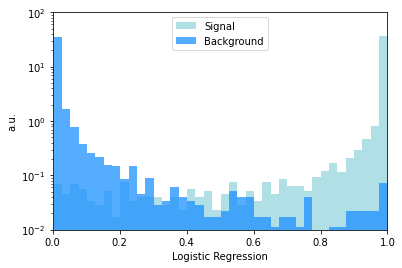

In [32]:
mass = 2000

mod, testPred, testLab = LogRegPCA(mass, pca_level=0.95, lpt=2)
mod_dictPCA['SingleLQ{:0>4}-muons'.format(mass)] = (mod, testPred, testLab)
# sig_yield, bkg_yield = CalculateYields(lumi, mass)

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
# plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
# plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
# plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Logistic Regression')
plt.ylabel('a.u.')

plt.legend()
plt.show()

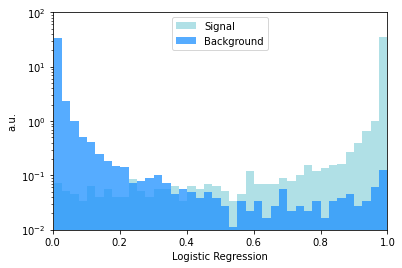

In [33]:
mass = 2500

mod, testPred, testLab = LogRegPCA(mass, pca_level=0.95, lpt=2)
mod_dictPCA['SingleLQ{:0>4}-muons'.format(mass)] = (mod, testPred, testLab)
# sig_yield, bkg_yield = CalculateYields(lumi, mass)

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
# plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
# plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
# plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Logistic Regression')
plt.ylabel('a.u.')

plt.legend()
plt.show()

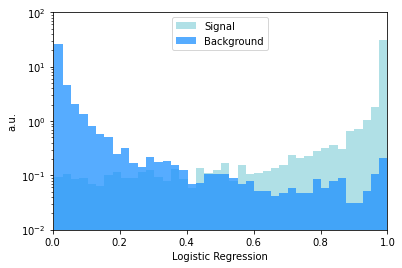

In [43]:
mass = 3000

mod, testPred, testLab = LogRegPCA(mass, pca_level=0.95, lpt=2)
mod_dictPCA['SingleLQ{:0>4}-muons'.format(mass)] = (mod, testPred, testLab)
# sig_yield, bkg_yield = CalculateYields(lumi, mass)

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
# plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
# plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
# plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Logistic Regression')
plt.ylabel('a.u.')

plt.legend()
plt.show()

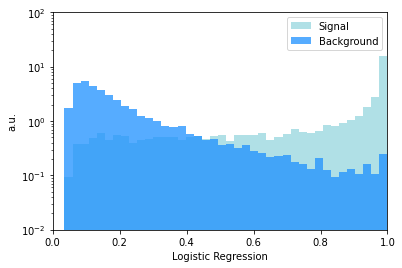

In [35]:
mass = 3500

mod, testPred, testLab = LogRegPCA(mass, pca_level=0.95, lpt=2)
mod_dictPCA['SingleLQ{:0>4}-muons'.format(mass)] = (mod, testPred, testLab)
# sig_yield, bkg_yield = CalculateYields(lumi, mass)

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
# plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
# plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
# plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Logistic Regression')
plt.ylabel('a.u.')

plt.legend()
plt.show()

## Significance study

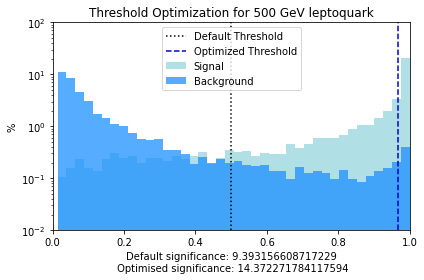

In [36]:
lumi = 1500
mass = 500

mod, testPred, testLab = mod_dict['SingleLQ{:0>4}-electrons'.format(mass)]
sig_yield, bkg_yield = CalculateYields(lumi, mass)

opt_threshold = mod.best_threshold(sig_yield, bkg_yield, testPred, testLab, sepbg=False)


sig_default = mod.significance(sig_yield,bkg_yield, tpr=mod.tpr(testLab, preds=testPred),
                             fpr=mod.fpr(testLab, preds=testPred), sepbg=False)
sig_opt = opt_threshold[1]

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Default significance: {}\n Optimised significance: {}'.format(sig_default, sig_opt))
plt.ylabel('%')

plt.legend()
plt.tight_layout()
#plt.show()
plt.savefig('LogReg/LogReg_LQ500_opt.pdf')

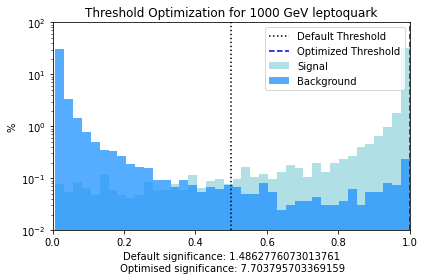

In [37]:
lumi = 1500
mass = 1000

mod, testPred, testLab = mod_dict['SingleLQ{:0>4}-electrons'.format(mass)]
sig_yield, bkg_yield = CalculateYields(lumi, mass)

opt_threshold = mod.best_threshold(sig_yield, bkg_yield, testPred, testLab, sepbg=False)


sig_default = mod.significance(sig_yield,bkg_yield, tpr=mod.tpr(testLab, preds=testPred),
                             fpr=mod.fpr(testLab, preds=testPred), sepbg=False)
sig_opt = opt_threshold[1]

plt.figure()
bin_edges, sig_bins, bg_bins = mod.predict_hist(testPred, testLab, num_bins=40, sepbg=False)
plt.bar(bin_edges[:-1], sig_bins, width=np.diff(bin_edges), alpha=1, align="edge", color='powderblue', label="Signal")
plt.bar(bin_edges[:-1], bg_bins, width=np.diff(bin_edges), alpha=0.75, align="edge", color='dodgerblue', label="Background")
plt.axvline(x=0.5, label='Default Threshold', c='k', ls=':')
plt.axvline(x=opt_threshold[0], label='Optimized Threshold', c='mediumblue', ls='--')
plt.yscale('log')
plt.title('Threshold Optimization for {} GeV leptoquark'.format(mass))
plt.ylim([10**-2, 10**2])
plt.xlim([0, 1])
plt.xlabel('Default significance: {}\n Optimised significance: {}'.format(sig_default, sig_opt))
plt.ylabel('%')

plt.legend()
plt.tight_layout()
#plt.show()
plt.savefig('LogReg/LogReg_LQ1000_opt.pdf')

### Individual significances

In [45]:
masses = [500, 1000, 1500, 2000, 2500, 3000, 3500]

signi_def_e = []
signi_opt_e =[]
signi_def_mu = []
signi_opt_mu = []

for mass in masses:
    if mass<=1000:
        mod1, testPred1, testLab1 = mod_dict['SingleLQ{:0>4}-electrons'.format(mass)]
        mod2, testPred2, testLab2 = mod_dict['SingleLQ{:0>4}-muons'.format(mass)]
    else:
        mod1, testPred1, testLab1 = mod_dictPCA['SingleLQ{:0>4}-electrons'.format(mass)]        
        mod2, testPred2, testLab2 = mod_dictPCA['SingleLQ{:0>4}-muons'.format(mass)]
        
    
    sig_yield1, bkg_yield1 = CalculateYields(1.0, mass)
    sig_yield2, bkg_yield2 = CalculateYields(1.0, mass, lpt=2)
        
    signi_def_e += [mod1.significance(sig_yield1,bkg_yield1, tpr=mod1.tpr(testLab1, preds=testPred1),
                                 fpr=mod1.fpr(testLab1, preds=testPred1), sepbg=False)]
    signi_def_mu += [mod1.significance(sig_yield2,bkg_yield2, tpr=mod2.tpr(testLab2, preds=testPred2),
                                 fpr=mod2.fpr(testLab2, preds=testPred2), sepbg=False)]
    
    opt_threshold1 = mod1.best_threshold(sig_yield1, bkg_yield1, testPred1, testLab1, sepbg=False)
    
    opt_threshold2 = mod2.best_threshold(sig_yield2, bkg_yield2, testPred2, testLab2, sepbg=False)
    
    signi_opt_e += [opt_threshold1[1]]
    signi_opt_mu += [opt_threshold2[1]]
    
    
signi_def_e = np.array(signi_def_e)
signi_opt_e = np.array(signi_opt_e)
signi_def_mu = np.array(signi_def_mu)
signi_opt_mu = np.array(signi_opt_mu)

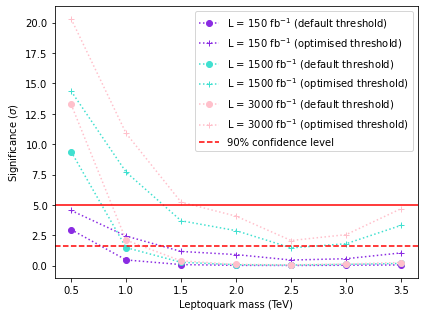

In [39]:
plt.figure(figsize=(6,4.5))
plt.plot(np.array(masses)*1.0e-3, np.sqrt(150)*signi_def_e, color = 'blueviolet', ls = ':', marker='o', label=r'L = 150 fb$^{-1}$ (default threshold)')
plt.plot(np.array(masses)*1.0e-3, np.sqrt(150)*signi_opt_e, color = 'blueviolet', ls = ':', marker='+', label=r'L = 150 fb$^{-1}$ (optimised threshold)')
plt.plot(np.array(masses)*1.0e-3, np.sqrt(1500)*signi_def_e, color = 'turquoise', ls = ':', marker='o', label=r'L = 1500 fb$^{-1}$ (default threshold)')
plt.plot(np.array(masses)*1.0e-3, np.sqrt(1500)*signi_opt_e, color = 'turquoise', ls = ':', marker='+', label=r'L = 1500 fb$^{-1}$ (optimised threshold)')
plt.plot(np.array(masses)*1.0e-3, np.sqrt(3000)*signi_def_e, color = 'pink', ls = ':', marker='o', label=r'L = 3000 fb$^{-1}$ (default threshold)')
plt.plot(np.array(masses)*1.0e-3, np.sqrt(3000)*signi_opt_e, color = 'pink', ls = ':', marker='+', label=r'L = 3000 fb$^{-1}$ (optimised threshold)')
plt.axhline(y=5, c='r')
plt.axhline(y=1.645, c='r', ls='--', label='90% confidence level')
plt.xlabel('Leptoquark mass (TeV)')
plt.ylabel(r'Significance ($\sigma$)')

plt.legend()

plt.tight_layout()
plt.savefig('LogReg/significance_electrons.pdf')

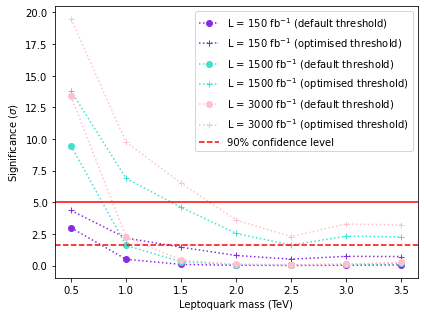

In [46]:
plt.figure(figsize=(6,4.5))
plt.plot(np.array(masses)*1.0e-3, np.sqrt(150)*signi_def_mu, color = 'blueviolet', ls = ':', marker='o', label=r'L = 150 fb$^{-1}$ (default threshold)')
plt.plot(np.array(masses)*1.0e-3, np.sqrt(150)*signi_opt_mu, color = 'blueviolet', ls = ':', marker='+', label=r'L = 150 fb$^{-1}$ (optimised threshold)')
plt.plot(np.array(masses)*1.0e-3, np.sqrt(1500)*signi_def_mu, color = 'turquoise', ls = ':', marker='o', label=r'L = 1500 fb$^{-1}$ (default threshold)')
plt.plot(np.array(masses)*1.0e-3, np.sqrt(1500)*signi_opt_mu, color = 'turquoise', ls = ':', marker='+', label=r'L = 1500 fb$^{-1}$ (optimised threshold)')
plt.plot(np.array(masses)*1.0e-3, np.sqrt(3000)*signi_def_mu, color = 'pink', ls = ':', marker='o', label=r'L = 3000 fb$^{-1}$ (default threshold)')
plt.plot(np.array(masses)*1.0e-3, np.sqrt(3000)*signi_opt_mu, color = 'pink', ls = ':', marker='+', label=r'L = 3000 fb$^{-1}$ (optimised threshold)')
plt.axhline(y=5, c='r')
plt.axhline(y=1.645, c='r', ls='--', label='90% confidence level')
plt.xlabel('Leptoquark mass (TeV)')
plt.ylabel(r'Significance ($\sigma$)')

plt.legend()

plt.tight_layout()
plt.savefig('LogReg/significance_muons.pdf')

In [47]:
masses = [500, 1000, 1500, 2000, 2500, 3000, 3500]

significance = []
significance_opt = []

for mass in masses:
    if mass<=1000:
        mod1, testPred1, testLab1 = mod_dict['SingleLQ{:0>4}-electrons'.format(mass)]
        mod2, testPred2, testLab2 = mod_dict['SingleLQ{:0>4}-muons'.format(mass)]
    else:
        mod1, testPred1, testLab1 = mod_dictPCA['SingleLQ{:0>4}-electrons'.format(mass)]
        mod2, testPred2, testLab2 = mod_dictPCA['SingleLQ{:0>4}-muons'.format(mass)]
    
    sig_yield1, bkg_yield1 = CalculateYields(1.0, mass)
    sig_yield2, bkg_yield2 = CalculateYields(1.0, mass, lpt=2)
    
    tpr1 = mod1.tpr(testLab1, preds=testPred1)
    fpr1 = mod1.fpr(testLab1, preds=testPred1)
    
    tpr2 = mod2.tpr(testLab2, preds=testPred2)
    fpr2 = mod2.fpr(testLab2, preds=testPred2)

    opt_threshold1 = mod1.best_threshold(sig_yield1, bkg_yield1, testPred1, testLab1, sepbg=False)
    
    opt_threshold2 = mod2.best_threshold(sig_yield2, bkg_yield2, testPred2, testLab2, sepbg=False)

    sig_default1 = mod1.significance(sig_yield1,bkg_yield1, tpr=tpr1,
                                 fpr=fpr1, sepbg=False)
    
    sig_default2 = mod2.significance(sig_yield2,bkg_yield2, tpr=tpr2,
                                 fpr=fpr2, sepbg=False)
    sig_opt1 = opt_threshold1[1]
    sig_opt2 = opt_threshold2[1]
    
    s = sig_yield1*tpr1 + sig_yield2*tpr2
    b = bkg_yield1*fpr1 + bkg_yield2*fpr2
    
    significance += [s/np.sqrt(s+b)]
    
    s = sig_yield1*opt_threshold1[2] + sig_yield2*opt_threshold2[2]
    b = bkg_yield1*opt_threshold1[3] + bkg_yield2*opt_threshold2[3]
    
    significance_opt += [s/np.sqrt(s+b)]
    
    
    
significance = np.array(significance)
significance_opt = np.array(significance_opt)

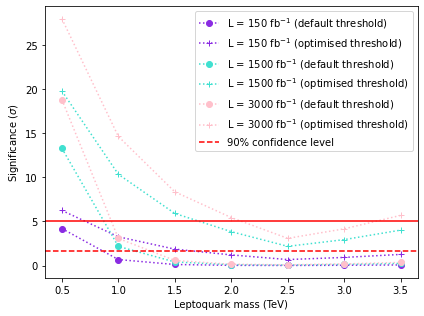

In [48]:
plt.figure(figsize=(6,4.5))
plt.plot(np.array(masses)*1.0e-3, np.sqrt(150)*significance, color = 'blueviolet', ls = ':', marker='o', label=r'L = 150 fb$^{-1}$ (default threshold)')
plt.plot(np.array(masses)*1.0e-3, np.sqrt(150)*significance_opt, color = 'blueviolet', ls = ':', marker='+', label=r'L = 150 fb$^{-1}$ (optimised threshold)')
plt.plot(np.array(masses)*1.0e-3, np.sqrt(1500)*significance, color = 'turquoise', ls = ':', marker='o', label=r'L = 1500 fb$^{-1}$ (default threshold)')
plt.plot(np.array(masses)*1.0e-3, np.sqrt(1500)*significance_opt, color = 'turquoise', ls = ':', marker='+', label=r'L = 1500 fb$^{-1}$ (optimised threshold)')
plt.plot(np.array(masses)*1.0e-3, np.sqrt(3000)*significance, color = 'pink', ls = ':', marker='o', label=r'L = 3000 fb$^{-1}$ (default threshold)')
plt.plot(np.array(masses)*1.0e-3, np.sqrt(3000)*significance_opt, color = 'pink', ls = ':', marker='+', label=r'L = 3000 fb$^{-1}$ (optimised threshold)')
plt.axhline(y=5, c='r')
plt.axhline(y=1.645, c='r', ls='--', label='90% confidence level')
# plt.yscale('log')
plt.xlabel('Leptoquark mass (TeV)')
plt.ylabel(r'Significance ($\sigma$)')

plt.legend()

plt.tight_layout()
#plt.show()
plt.savefig('LogReg/significance_ovr.pdf')